##### In this notebook, we will try the **Local Model approach**, where we train one model per district. Each model then will make individual forecasts for the month of April 2023, which will then be compared with the test set for that particular district.

In [2]:
import time
import warnings
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from tqdm.auto import tqdm
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

plt.rcParams["font.weight"] = 'bold'
seed=42

In [19]:
districts = np.sort(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .select('DISTRICT')
    .unique()
    .collect(streaming=True)
    .to_series()
    .to_list()
)

districts

array(['Arnavutköy', 'Ataşehir', 'Avcılar', 'Bahçelievler', 'Bakırköy',
       'Bayrampaşa', 'Bağcılar', 'Başakşehir', 'Beykoz', 'Beylikdüzü',
       'Beyoğlu', 'Beşiktaş', 'Büyükçekmece', 'Esenler', 'Esenyurt',
       'Eyüpsultan', 'Fatih', 'Gaziosmanpaşa', 'Güngören', 'Kadıköy',
       'Kartal', 'Kâğıthane', 'Küçükçekmece', 'Maltepe', 'Pendik',
       'Sancaktepe', 'Sarıyer', 'Silivri', 'Sultanbeyli', 'Sultangazi',
       'Tuzla', 'Zeytinburnu', 'Çatalca', 'Çekmeköy', 'Ümraniye',
       'Üsküdar', 'Şişli'], dtype='<U13')

In [3]:
def filter_df(district: str) -> pd.DataFrame:
    """
    Concat Train and validation test set, then fiter dataset by district.
    Finally sort dataset by DATE_TIME and GEOHASH.
    Return as Pandas DataFrame
    """
    train = (
        pl.concat([
            (
                pl.read_parquet("datasets/19_model/train.zstd")
                .filter(pl.col('DISTRICT').eq(district))
                .with_columns(pl.col('GEOHASH')
                            .cast(pl.Utf8)
                            .cast(pl.Categorical))
            ),
            (
                pl.read_parquet("datasets/19_model/valid.zstd")
                .filter(pl.col('DISTRICT').eq(district))
                .with_columns(pl.col('GEOHASH')
                            .cast(pl.Utf8)
                            .cast(pl.Categorical))
            )
        ], how='vertical')
        .drop('DISTRICT')
        .sort(['DATE_TIME', 'GEOHASH'])
        .to_pandas()
        .set_index('DATE_TIME')
    )

    return train

In [4]:
def filter_test(district: str) -> pd.DataFrame:
    """
    Fiter test dataset by district.
    Then sort dataset by DATE_TIME and GEOHASH.
    Replace TD_LAG1, TD_LAG24 and TD_LAG168 except for the 1st hour with null.
    Return as Pandas DataFrame
    """
    test = (
        pl.read_parquet("datasets/19_model/test.zstd")
        .filter(pl.col('DISTRICT').eq(district))
        .with_columns(pl.col('GEOHASH')
                    .cast(pl.Utf8)
                    .cast(pl.Categorical))
        .sort(['DATE_TIME', 'GEOHASH'])
        .drop('DISTRICT')
        .to_pandas()

        # Replacing all TD_LAG1, TD_LAG24 and TD_LAG168 with null values except for the first hour
        .assign(TD_LAG1=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG1'], np.nan),
                TD_LAG24=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG24'], np.nan),
                TD_LAG168=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG168'], np.nan))

        .set_index('DATE_TIME')
    )

    return test

In [5]:
def create_pipeline(train: pd.DataFrame) -> sklearn.pipeline:
    """
    Create Feature Engineering pipline with Light Gradient Boosting Model
    """
    cat_cols = [col for col in train.columns if train[col].dtype=='category']
    time_cols = ["month", "day_of_month", "hour", "day_of_week"] #excluding year

    # Extract date time features
    dt_feats=DatetimeFeatures(variables='index', features_to_extract = ["year", "month", "day_of_month", "hour", "day_of_week"])

    # Encode categorical columns with numbers.
    ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

    # Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
    cf_encoder=CyclicalFeatures(variables=time_cols, drop_original=True)

    # LGBM
    lgbm_params = {'n_estimators': 266, 
                   'num_leaves': 87,
                   'colsample_bytree': 0.676,
                   'learning_rate': 0.0223, 
                   'max_depth': 6, 
                   'reg_alpha': 2.3, 
                   'reg_lambda': 0.011, 
                   'min_child_weight': 0.0017}

    lgbm=LGBMRegressor(**lgbm_params, n_jobs=-1, random_state=seed)

    #Creating encoder pipeline
    pipeline = make_pipeline(
        (dt_feats), # Extract date time features
        (ord_encoder), # Ordinal Encoder
        (cf_encoder), # Cyclical Feature
        (lgbm) #LGBM model
    )

    return pipeline

In [6]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
class BlockingTimeSeriesSplit():
    """
    Class to that will return indices of each split for Cross Validation.
    """
    def __init__(self, n_splits: int):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.9 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [7]:
def cv_train(
        pipeline: sklearn.pipeline,
        train: pd.DataFrame
    ) -> sklearn.pipeline:
    """
    Function that trains the model using cross validation on the train set.
    """
    X_df = train.drop('NUMBER_OF_VEHICLES', axis=1)
    y_df = train['NUMBER_OF_VEHICLES']

    tss = BlockingTimeSeriesSplit(n_splits=5)

    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()

    # start timer
    loop_time = time.time()

    for train_index, test_index in tss.split(X_df, y_df):

        X_train_cv, X_test_cv = X_df.iloc[train_index], X_df.iloc[test_index]
        y_train_cv, y_test_cv = y_df.iloc[train_index], y_df.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = np.round(pipeline.predict(X_test_cv))

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f} | Time taken: {(time.time() - loop_time)/60:.2f} min")

        rmse_values.append(rmse)
        count += 1
        loop_time = time.time()
        
    # Print the average MSE over all folds
    print()
    print(f"Average RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")

    return pipeline

In [8]:
def make_forecast(
        pipeline: sklearn.pipeline, 
        train: pd.DataFrame, 
        test: pd.DataFrame, 
        district: str
    ) -> pd.DataFrame:
    
    """
    Function that forecasts traffic density for the month of April 2023.
    Returns a dataframe with actual TD, Forecasted TD, GEOHASH and distrcit.
    """

    actual_forecast_test = (
        pd.concat([train, test])[['GEOHASH', 'NUMBER_OF_VEHICLES']]
        .assign(FORECAST=lambda x: np.where(x.index < "2023-04-01", x['NUMBER_OF_VEHICLES'], np.nan),
                DISTRICT=district)
    )

    forecast_horizon = pd.date_range("2023-04-01 00:00:00", "2023-04-30 23:00:00", freq='H')
    
    for date in tqdm(forecast_horizon):

        if date==pd.to_datetime("2023-04-01 00:00:00"):
            
            X = test.drop('NUMBER_OF_VEHICLES', axis=1).loc[date]
            forecast = pipeline.predict(X)
            actual_forecast_test.loc[date, 'FORECAST'] = np.round(forecast)

        else:
            # assign previous hour forecast TD to current hour TD_LAG1
            test.loc[date, "TD_LAG1"] = actual_forecast_test.loc[date-pd.offsets.Hour(1), "FORECAST"].values

            # assign previous 24th hour forecast TD to current hour TD_LAG24
            test.loc[date, "TD_LAG24"] = actual_forecast_test.loc[date-pd.offsets.Hour(24), "FORECAST"].values

            # assign previous 168th hour forecast TD to current hour TD_LAG168
            test.loc[date, "TD_LAG168"] = actual_forecast_test.loc[date-pd.offsets.Hour(168), "FORECAST"].values

            X = test.drop('NUMBER_OF_VEHICLES', axis=1).loc[date]
            forecast = pipeline.predict(X)
            actual_forecast_test.loc[date, 'FORECAST'] = np.round(forecast)

    return actual_forecast_test.loc["2023-04-01 00:00:00" : ]

# Training One Model Per District

In [9]:
actual_forecast_list = []

for district in tqdm(districts):
    print(district)

    # filtering data by districts
    train = filter_df(district=district)
    test = filter_test(district=district)

    # Creating pipeline
    pipeline = create_pipeline(train=train)
    
    # Corss validation and returning trained pipeline
    trained_pipeline = cv_train(pipeline=pipeline, train=train)

    # Make Forecasts
    actual_forecast_test = make_forecast(pipeline=trained_pipeline, 
                                         train=train, 
                                         test=test, 
                                         district=district)
    
    actual_forecast_list.append(actual_forecast_test)
    print()
    print()

  0%|          | 0/37 [00:00<?, ?it/s]

Arnavutköy
Cross Validating.....

cv #1: RMSE = 11.324 | Time taken: 0.25 min
cv #2: RMSE = 12.447 | Time taken: 0.24 min
cv #3: RMSE = 13.311 | Time taken: 0.24 min
cv #4: RMSE = 13.689 | Time taken: 0.27 min
cv #5: RMSE = 16.516 | Time taken: 0.27 min

Average RMSE: 13.457 ± 1.73


  0%|          | 0/720 [00:00<?, ?it/s]



Ataşehir
Cross Validating.....

cv #1: RMSE = 21.725 | Time taken: 0.17 min
cv #2: RMSE = 18.741 | Time taken: 0.15 min
cv #3: RMSE = 25.218 | Time taken: 0.15 min
cv #4: RMSE = 23.145 | Time taken: 0.16 min
cv #5: RMSE = 30.286 | Time taken: 0.18 min

Average RMSE: 23.823 ± 3.86


  0%|          | 0/720 [00:00<?, ?it/s]



Avcılar
Cross Validating.....

cv #1: RMSE = 32.031 | Time taken: 0.14 min
cv #2: RMSE = 28.120 | Time taken: 0.13 min
cv #3: RMSE = 29.916 | Time taken: 0.11 min
cv #4: RMSE = 29.569 | Time taken: 0.13 min
cv #5: RMSE = 36.737 | Time taken: 0.12 min

Average RMSE: 31.274 ± 3.00


  0%|          | 0/720 [00:00<?, ?it/s]



Bahçelievler
Cross Validating.....

cv #1: RMSE = 22.979 | Time taken: 0.14 min
cv #2: RMSE = 21.784 | Time taken: 0.13 min
cv #3: RMSE = 25.877 | Time taken: 0.13 min
cv #4: RMSE = 23.392 | Time taken: 0.11 min
cv #5: RMSE = 31.087 | Time taken: 0.13 min

Average RMSE: 25.024 ± 3.31


  0%|          | 0/720 [00:00<?, ?it/s]



Bakırköy
Cross Validating.....

cv #1: RMSE = 19.700 | Time taken: 0.17 min
cv #2: RMSE = 18.508 | Time taken: 0.15 min
cv #3: RMSE = 21.635 | Time taken: 0.15 min
cv #4: RMSE = 20.598 | Time taken: 0.13 min
cv #5: RMSE = 25.540 | Time taken: 0.14 min

Average RMSE: 21.196 ± 2.40


  0%|          | 0/720 [00:00<?, ?it/s]



Bayrampaşa
Cross Validating.....

cv #1: RMSE = 21.601 | Time taken: 0.10 min
cv #2: RMSE = 20.139 | Time taken: 0.12 min
cv #3: RMSE = 23.576 | Time taken: 0.09 min
cv #4: RMSE = 22.540 | Time taken: 0.10 min
cv #5: RMSE = 30.070 | Time taken: 0.10 min

Average RMSE: 23.585 ± 3.43


  0%|          | 0/720 [00:00<?, ?it/s]



Bağcılar
Cross Validating.....

cv #1: RMSE = 31.038 | Time taken: 0.20 min
cv #2: RMSE = 30.183 | Time taken: 0.17 min
cv #3: RMSE = 33.057 | Time taken: 0.22 min
cv #4: RMSE = 30.991 | Time taken: 0.19 min
cv #5: RMSE = 41.283 | Time taken: 0.19 min

Average RMSE: 33.311 ± 4.10


  0%|          | 0/720 [00:00<?, ?it/s]



Başakşehir
Cross Validating.....

cv #1: RMSE = 26.202 | Time taken: 0.22 min
cv #2: RMSE = 23.573 | Time taken: 0.28 min
cv #3: RMSE = 24.721 | Time taken: 0.21 min
cv #4: RMSE = 24.611 | Time taken: 0.20 min
cv #5: RMSE = 31.666 | Time taken: 0.19 min

Average RMSE: 26.155 ± 2.88


  0%|          | 0/720 [00:00<?, ?it/s]



Beykoz
Cross Validating.....

cv #1: RMSE = 19.229 | Time taken: 0.20 min
cv #2: RMSE = 17.415 | Time taken: 0.18 min
cv #3: RMSE = 20.926 | Time taken: 0.19 min
cv #4: RMSE = 19.432 | Time taken: 0.18 min
cv #5: RMSE = 22.524 | Time taken: 0.24 min

Average RMSE: 19.905 ± 1.72


  0%|          | 0/720 [00:00<?, ?it/s]



Beylikdüzü
Cross Validating.....

cv #1: RMSE = 22.754 | Time taken: 0.07 min
cv #2: RMSE = 21.213 | Time taken: 0.06 min
cv #3: RMSE = 27.589 | Time taken: 0.07 min
cv #4: RMSE = 27.654 | Time taken: 0.08 min
cv #5: RMSE = 33.578 | Time taken: 0.09 min

Average RMSE: 26.558 ± 4.35


  0%|          | 0/720 [00:00<?, ?it/s]



Beyoğlu
Cross Validating.....

cv #1: RMSE = 14.980 | Time taken: 0.19 min
cv #2: RMSE = 15.012 | Time taken: 0.10 min
cv #3: RMSE = 18.701 | Time taken: 0.11 min
cv #4: RMSE = 18.060 | Time taken: 0.12 min
cv #5: RMSE = 20.754 | Time taken: 0.09 min

Average RMSE: 17.501 ± 2.23


  0%|          | 0/720 [00:00<?, ?it/s]



Beşiktaş
Cross Validating.....

cv #1: RMSE = 20.306 | Time taken: 0.14 min
cv #2: RMSE = 17.763 | Time taken: 0.13 min
cv #3: RMSE = 23.434 | Time taken: 0.10 min
cv #4: RMSE = 20.556 | Time taken: 0.12 min
cv #5: RMSE = 24.686 | Time taken: 0.15 min

Average RMSE: 21.349 ± 2.45


  0%|          | 0/720 [00:00<?, ?it/s]



Büyükçekmece
Cross Validating.....

cv #1: RMSE = 15.757 | Time taken: 0.28 min
cv #2: RMSE = 14.170 | Time taken: 0.29 min
cv #3: RMSE = 16.001 | Time taken: 0.25 min
cv #4: RMSE = 14.883 | Time taken: 0.39 min
cv #5: RMSE = 16.842 | Time taken: 0.28 min

Average RMSE: 15.531 ± 0.92


  0%|          | 0/720 [00:00<?, ?it/s]



Esenler
Cross Validating.....

cv #1: RMSE = 18.530 | Time taken: 0.14 min
cv #2: RMSE = 18.356 | Time taken: 0.10 min
cv #3: RMSE = 18.856 | Time taken: 0.10 min
cv #4: RMSE = 17.867 | Time taken: 0.11 min
cv #5: RMSE = 22.032 | Time taken: 0.11 min

Average RMSE: 19.128 ± 1.49


  0%|          | 0/720 [00:00<?, ?it/s]



Esenyurt
Cross Validating.....

cv #1: RMSE = 23.509 | Time taken: 0.15 min
cv #2: RMSE = 21.897 | Time taken: 0.15 min
cv #3: RMSE = 25.800 | Time taken: 0.14 min
cv #4: RMSE = 24.637 | Time taken: 0.14 min
cv #5: RMSE = 30.637 | Time taken: 0.16 min

Average RMSE: 25.296 ± 2.96


  0%|          | 0/720 [00:00<?, ?it/s]



Eyüpsultan
Cross Validating.....

cv #1: RMSE = 20.498 | Time taken: 0.31 min
cv #2: RMSE = 20.261 | Time taken: 0.29 min
cv #3: RMSE = 21.967 | Time taken: 0.30 min
cv #4: RMSE = 22.053 | Time taken: 0.31 min
cv #5: RMSE = 25.688 | Time taken: 0.31 min

Average RMSE: 22.094 ± 1.94


  0%|          | 0/720 [00:00<?, ?it/s]



Fatih
Cross Validating.....

cv #1: RMSE = 13.642 | Time taken: 0.15 min
cv #2: RMSE = 12.870 | Time taken: 0.14 min
cv #3: RMSE = 15.382 | Time taken: 0.12 min
cv #4: RMSE = 14.942 | Time taken: 0.12 min
cv #5: RMSE = 17.562 | Time taken: 0.13 min

Average RMSE: 14.879 ± 1.61


  0%|          | 0/720 [00:00<?, ?it/s]



Gaziosmanpaşa
Cross Validating.....

cv #1: RMSE = 18.584 | Time taken: 0.10 min
cv #2: RMSE = 18.286 | Time taken: 0.11 min
cv #3: RMSE = 19.424 | Time taken: 0.08 min
cv #4: RMSE = 18.250 | Time taken: 0.08 min
cv #5: RMSE = 24.484 | Time taken: 0.09 min

Average RMSE: 19.806 ± 2.38


  0%|          | 0/720 [00:00<?, ?it/s]



Güngören
Cross Validating.....

cv #1: RMSE = 17.658 | Time taken: 0.09 min
cv #2: RMSE = 16.707 | Time taken: 0.09 min
cv #3: RMSE = 19.806 | Time taken: 0.07 min
cv #4: RMSE = 18.887 | Time taken: 0.07 min
cv #5: RMSE = 24.992 | Time taken: 0.07 min

Average RMSE: 19.610 ± 2.89


  0%|          | 0/720 [00:00<?, ?it/s]



Kadıköy
Cross Validating.....

cv #1: RMSE = 16.835 | Time taken: 0.18 min
cv #2: RMSE = 14.095 | Time taken: 0.16 min
cv #3: RMSE = 19.549 | Time taken: 0.16 min
cv #4: RMSE = 18.109 | Time taken: 0.17 min
cv #5: RMSE = 23.172 | Time taken: 0.15 min

Average RMSE: 18.352 ± 3.00


  0%|          | 0/720 [00:00<?, ?it/s]



Kartal
Cross Validating.....

cv #1: RMSE = 19.033 | Time taken: 0.15 min
cv #2: RMSE = 17.340 | Time taken: 0.16 min
cv #3: RMSE = 20.365 | Time taken: 0.18 min
cv #4: RMSE = 19.768 | Time taken: 0.16 min
cv #5: RMSE = 24.337 | Time taken: 0.15 min

Average RMSE: 20.169 ± 2.32


  0%|          | 0/720 [00:00<?, ?it/s]



Kâğıthane
Cross Validating.....

cv #1: RMSE = 21.877 | Time taken: 0.10 min
cv #2: RMSE = 21.479 | Time taken: 0.09 min
cv #3: RMSE = 26.295 | Time taken: 0.09 min
cv #4: RMSE = 23.372 | Time taken: 0.08 min
cv #5: RMSE = 29.835 | Time taken: 0.10 min

Average RMSE: 24.572 ± 3.13


  0%|          | 0/720 [00:00<?, ?it/s]



Küçükçekmece
Cross Validating.....

cv #1: RMSE = 17.502 | Time taken: 0.16 min
cv #2: RMSE = 16.201 | Time taken: 0.14 min
cv #3: RMSE = 18.029 | Time taken: 0.13 min
cv #4: RMSE = 16.850 | Time taken: 0.13 min
cv #5: RMSE = 20.743 | Time taken: 0.13 min

Average RMSE: 17.865 ± 1.56


  0%|          | 0/720 [00:00<?, ?it/s]



Maltepe
Cross Validating.....

cv #1: RMSE = 20.295 | Time taken: 0.12 min
cv #2: RMSE = 16.895 | Time taken: 0.11 min
cv #3: RMSE = 21.932 | Time taken: 0.14 min
cv #4: RMSE = 21.921 | Time taken: 0.12 min
cv #5: RMSE = 25.841 | Time taken: 0.12 min

Average RMSE: 21.377 ± 2.89


  0%|          | 0/720 [00:00<?, ?it/s]



Pendik
Cross Validating.....

cv #1: RMSE = 21.257 | Time taken: 0.21 min
cv #2: RMSE = 20.085 | Time taken: 0.19 min
cv #3: RMSE = 26.378 | Time taken: 0.21 min
cv #4: RMSE = 26.522 | Time taken: 0.20 min
cv #5: RMSE = 30.830 | Time taken: 0.22 min

Average RMSE: 25.014 ± 3.91


  0%|          | 0/720 [00:00<?, ?it/s]



Sancaktepe
Cross Validating.....

cv #1: RMSE = 21.830 | Time taken: 0.10 min
cv #2: RMSE = 20.186 | Time taken: 0.10 min
cv #3: RMSE = 26.289 | Time taken: 0.10 min
cv #4: RMSE = 24.479 | Time taken: 0.12 min
cv #5: RMSE = 30.667 | Time taken: 0.14 min

Average RMSE: 24.690 ± 3.66


  0%|          | 0/720 [00:00<?, ?it/s]



Sarıyer
Cross Validating.....

cv #1: RMSE = 17.699 | Time taken: 0.18 min
cv #2: RMSE = 16.430 | Time taken: 0.17 min
cv #3: RMSE = 19.370 | Time taken: 0.17 min
cv #4: RMSE = 16.662 | Time taken: 0.17 min
cv #5: RMSE = 21.043 | Time taken: 0.19 min

Average RMSE: 18.241 ± 1.74


  0%|          | 0/720 [00:00<?, ?it/s]



Silivri
Cross Validating.....

cv #1: RMSE = 9.975 | Time taken: 0.34 min
cv #2: RMSE = 8.947 | Time taken: 0.31 min
cv #3: RMSE = 8.471 | Time taken: 0.32 min
cv #4: RMSE = 8.540 | Time taken: 0.33 min
cv #5: RMSE = 8.475 | Time taken: 0.32 min

Average RMSE: 8.881 ± 0.57


  0%|          | 0/720 [00:00<?, ?it/s]



Sultanbeyli
Cross Validating.....

cv #1: RMSE = 22.738 | Time taken: 0.06 min
cv #2: RMSE = 20.926 | Time taken: 0.05 min
cv #3: RMSE = 30.662 | Time taken: 0.05 min
cv #4: RMSE = 28.565 | Time taken: 0.06 min
cv #5: RMSE = 36.717 | Time taken: 0.06 min

Average RMSE: 27.922 ± 5.68


  0%|          | 0/720 [00:00<?, ?it/s]



Sultangazi
Cross Validating.....

cv #1: RMSE = 20.123 | Time taken: 0.09 min
cv #2: RMSE = 18.153 | Time taken: 0.10 min
cv #3: RMSE = 18.643 | Time taken: 0.08 min
cv #4: RMSE = 17.731 | Time taken: 0.09 min
cv #5: RMSE = 22.897 | Time taken: 0.10 min

Average RMSE: 19.509 ± 1.88


  0%|          | 0/720 [00:00<?, ?it/s]



Tuzla
Cross Validating.....

cv #1: RMSE = 24.705 | Time taken: 0.11 min
cv #2: RMSE = 24.315 | Time taken: 0.11 min
cv #3: RMSE = 30.120 | Time taken: 0.09 min
cv #4: RMSE = 29.218 | Time taken: 0.11 min
cv #5: RMSE = 34.541 | Time taken: 0.10 min

Average RMSE: 28.580 ± 3.78


  0%|          | 0/720 [00:00<?, ?it/s]



Zeytinburnu
Cross Validating.....

cv #1: RMSE = 17.646 | Time taken: 0.08 min
cv #2: RMSE = 16.573 | Time taken: 0.07 min
cv #3: RMSE = 20.127 | Time taken: 0.06 min
cv #4: RMSE = 18.345 | Time taken: 0.06 min
cv #5: RMSE = 22.867 | Time taken: 0.06 min

Average RMSE: 19.112 ± 2.21


  0%|          | 0/720 [00:00<?, ?it/s]



Çatalca
Cross Validating.....

cv #1: RMSE = 9.657 | Time taken: 0.14 min
cv #2: RMSE = 9.407 | Time taken: 0.14 min
cv #3: RMSE = 9.673 | Time taken: 0.13 min
cv #4: RMSE = 10.068 | Time taken: 0.13 min
cv #5: RMSE = 10.865 | Time taken: 0.15 min

Average RMSE: 9.934 ± 0.51


  0%|          | 0/720 [00:00<?, ?it/s]



Çekmeköy
Cross Validating.....

cv #1: RMSE = 16.429 | Time taken: 0.16 min
cv #2: RMSE = 15.640 | Time taken: 0.14 min
cv #3: RMSE = 18.104 | Time taken: 0.14 min
cv #4: RMSE = 17.489 | Time taken: 0.16 min
cv #5: RMSE = 20.786 | Time taken: 0.23 min

Average RMSE: 17.689 ± 1.77


  0%|          | 0/720 [00:00<?, ?it/s]



Ümraniye
Cross Validating.....

cv #1: RMSE = 23.226 | Time taken: 0.16 min
cv #2: RMSE = 20.355 | Time taken: 0.15 min
cv #3: RMSE = 26.356 | Time taken: 0.19 min
cv #4: RMSE = 23.985 | Time taken: 0.18 min
cv #5: RMSE = 31.144 | Time taken: 0.26 min

Average RMSE: 25.013 ± 3.62


  0%|          | 0/720 [00:00<?, ?it/s]



Üsküdar
Cross Validating.....

cv #1: RMSE = 15.244 | Time taken: 0.17 min
cv #2: RMSE = 13.018 | Time taken: 0.15 min
cv #3: RMSE = 17.664 | Time taken: 0.13 min
cv #4: RMSE = 16.748 | Time taken: 0.13 min
cv #5: RMSE = 21.243 | Time taken: 0.14 min

Average RMSE: 16.783 ± 2.73


  0%|          | 0/720 [00:00<?, ?it/s]



Şişli
Cross Validating.....

cv #1: RMSE = 19.864 | Time taken: 0.07 min
cv #2: RMSE = 18.983 | Time taken: 0.08 min
cv #3: RMSE = 24.130 | Time taken: 0.07 min
cv #4: RMSE = 22.507 | Time taken: 0.07 min
cv #5: RMSE = 28.035 | Time taken: 0.08 min

Average RMSE: 22.704 ± 3.24


  0%|          | 0/720 [00:00<?, ?it/s]

In [10]:
all_districts_forecasts = pd.concat(actual_forecast_list)
all_districts_forecasts.to_csv("local_model_forecasts.csv")

In [8]:
all_districts_forecasts = pd.read_csv("../local_model_forecasts.csv", parse_dates=['DATE_TIME'], 
                                      index_col=['DATE_TIME'])

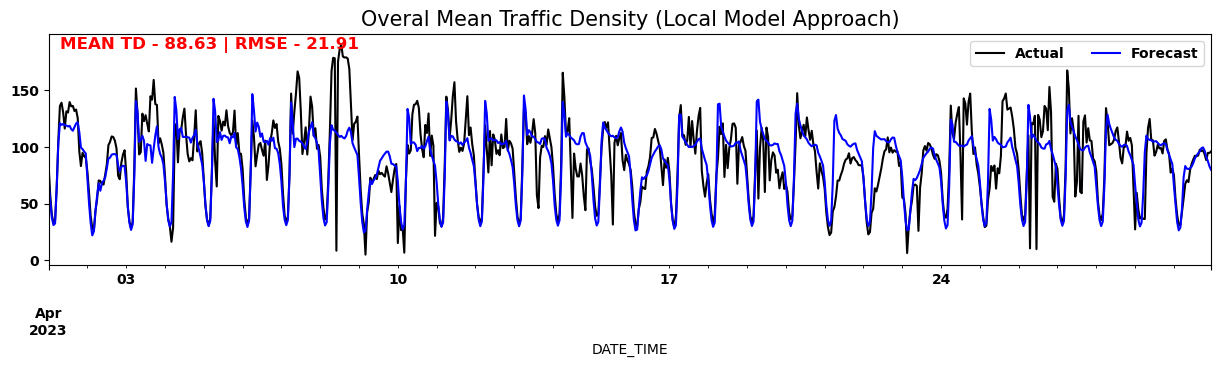

In [9]:
temp_df = (
    all_districts_forecasts
    .resample('H')[['NUMBER_OF_VEHICLES', 'FORECAST']].mean()
)


rmse = mean_squared_error(
    y_true=temp_df['NUMBER_OF_VEHICLES'],
    y_pred=temp_df['FORECAST'],
    squared=False
)
    
mean_td = temp_df['NUMBER_OF_VEHICLES'].mean()


ax = (
    temp_df
    .plot(figsize=(15, 3), color=['k', 'blue'])
)

ax.set_title('Overal Mean Traffic Density (Local Model Approach)', fontsize=15)

ax.text(.01, .99, f'MEAN TD - {mean_td:.2f} | RMSE - {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.legend(ncol=2, loc='upper right', labels=['Actual', 'Forecast']);

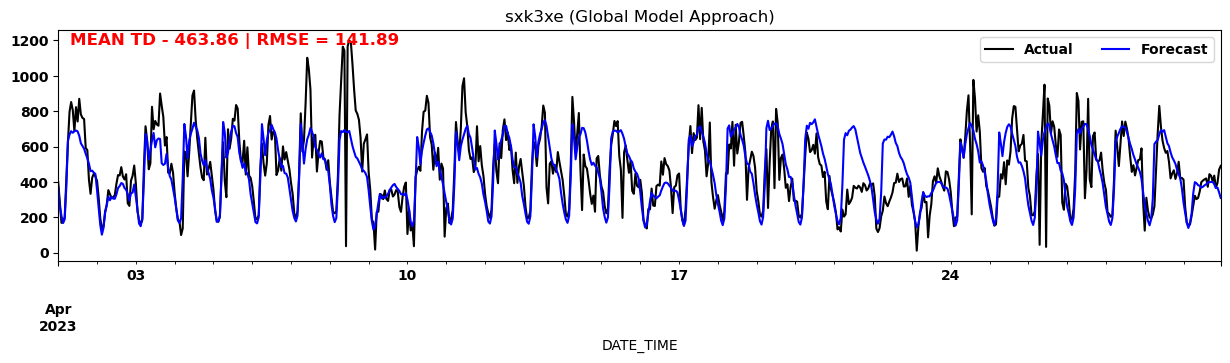

In [16]:
ax = (
    all_districts_forecasts.query("GEOHASH=='sxk3xe'")
    .plot(y=['NUMBER_OF_VEHICLES', 'FORECAST'], figsize=(15, 3), color=['k', 'blue'])
)

rmse = mean_squared_error(
    y_true=all_districts_forecasts.query("GEOHASH=='sxk3xe'")['NUMBER_OF_VEHICLES'],
    y_pred=all_districts_forecasts.query("GEOHASH=='sxk3xe'")['FORECAST'],
    squared=False
)

mean_td = all_districts_forecasts.query("GEOHASH=='sxk3xe'")['NUMBER_OF_VEHICLES'].mean()

ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.set_title('sxk3xe (Global Model Approach)')
ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right");

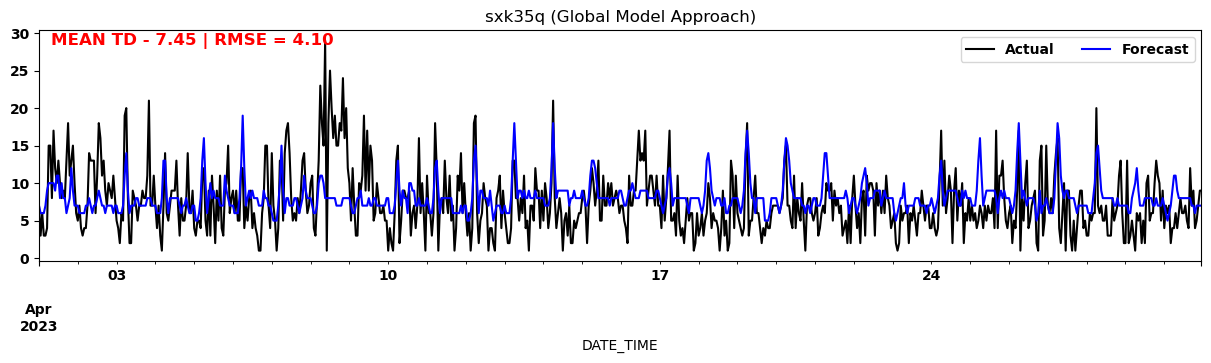

In [17]:
ax = (
    all_districts_forecasts.query("GEOHASH=='sxk35q'")
    .plot(y=['NUMBER_OF_VEHICLES', 'FORECAST'], figsize=(15, 3), color=['k', 'blue'])
)

rmse = mean_squared_error(
    y_true=all_districts_forecasts.query("GEOHASH=='sxk35q'")['NUMBER_OF_VEHICLES'],
    y_pred=all_districts_forecasts.query("GEOHASH=='sxk35q'")['FORECAST'],
    squared=False
)

mean_td = all_districts_forecasts.query("GEOHASH=='sxk35q'")['NUMBER_OF_VEHICLES'].mean()

ax.text(0.01, 0.99, f'MEAN TD - {mean_td:.2f} | RMSE = {rmse:.2f}', ha='left', va='top', 
        transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')

ax.set_title('sxk35q (Global Model Approach)')
ax.legend(labels=["Actual", "Forecast"], ncol=2, loc="upper right");

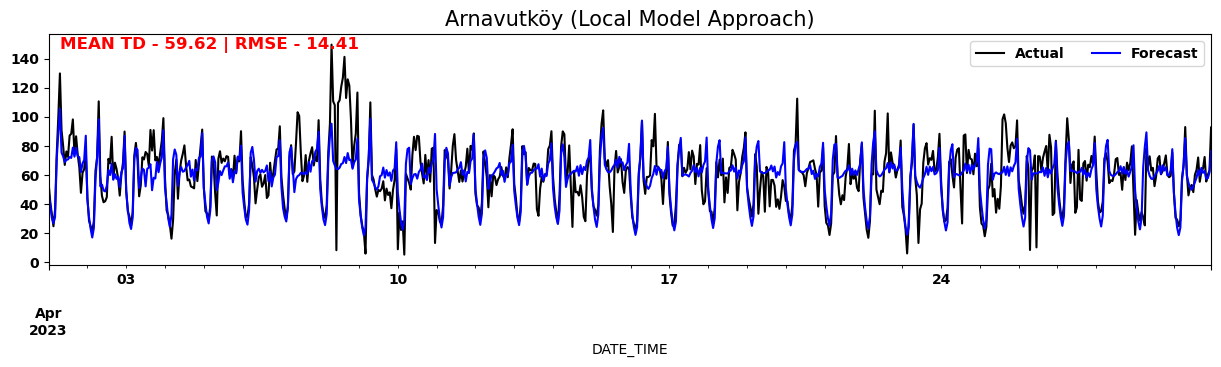

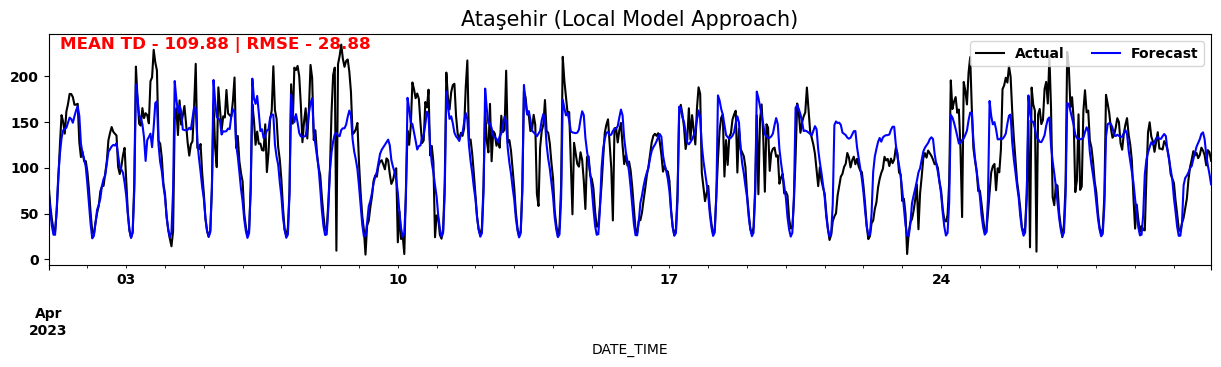

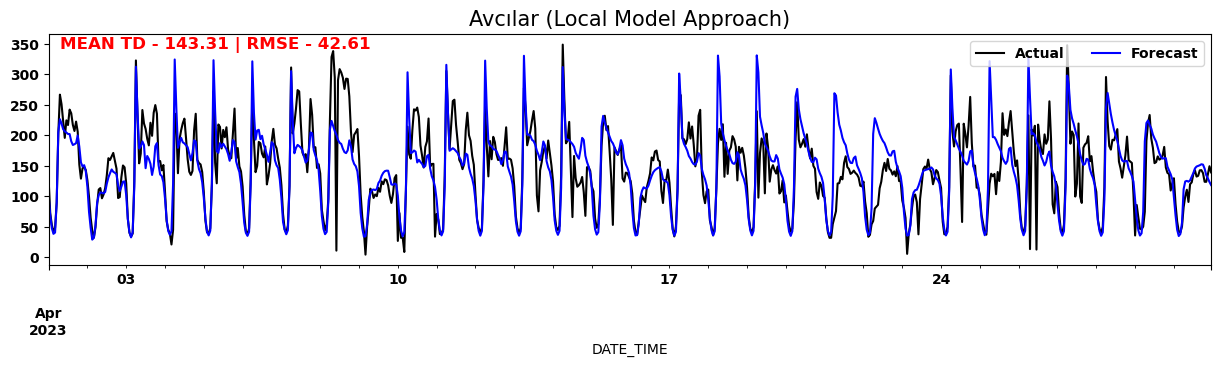

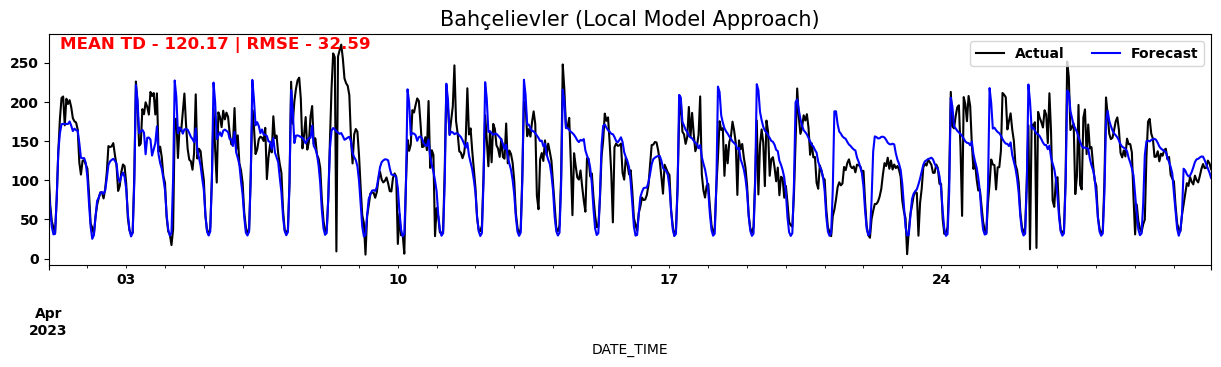

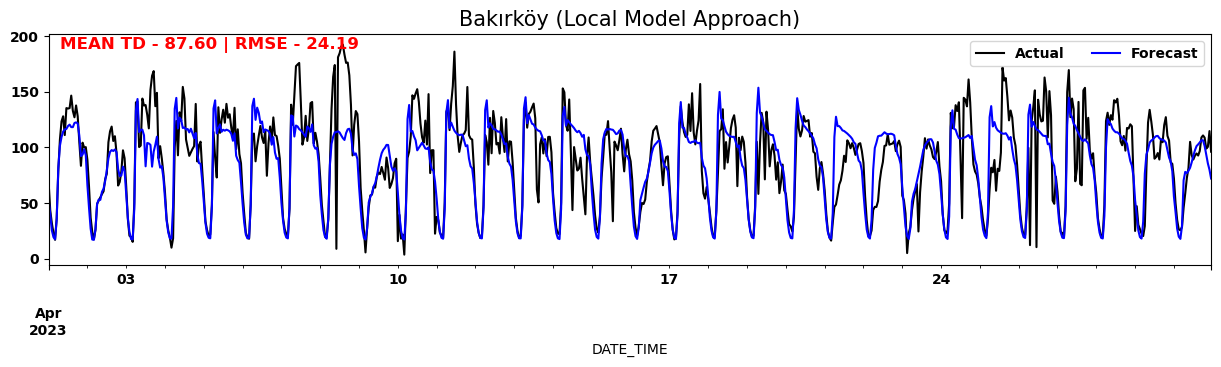

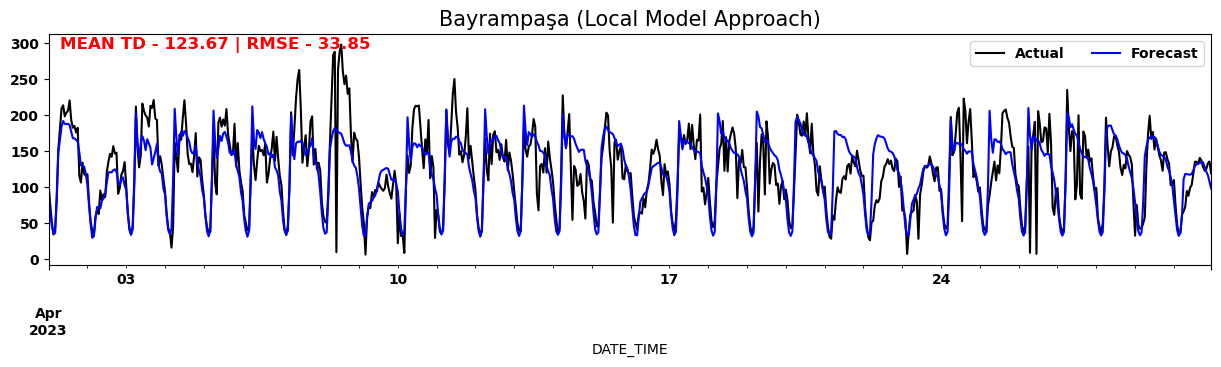

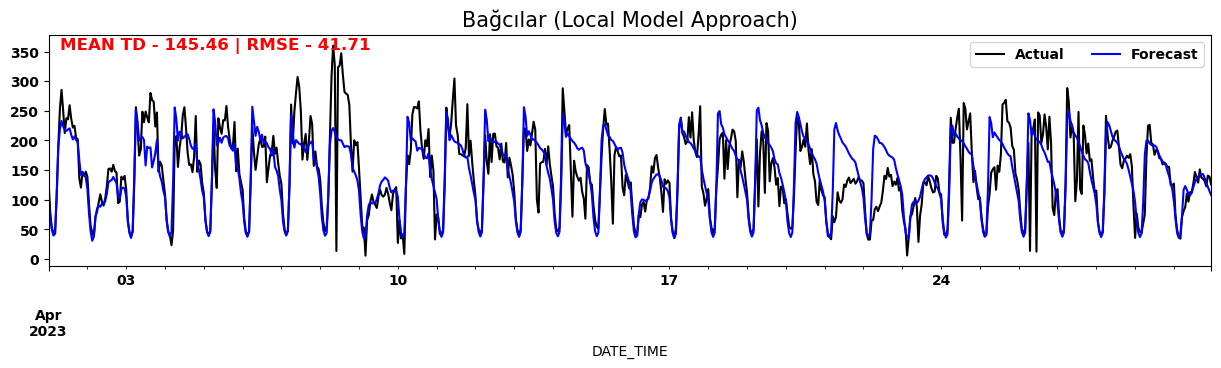

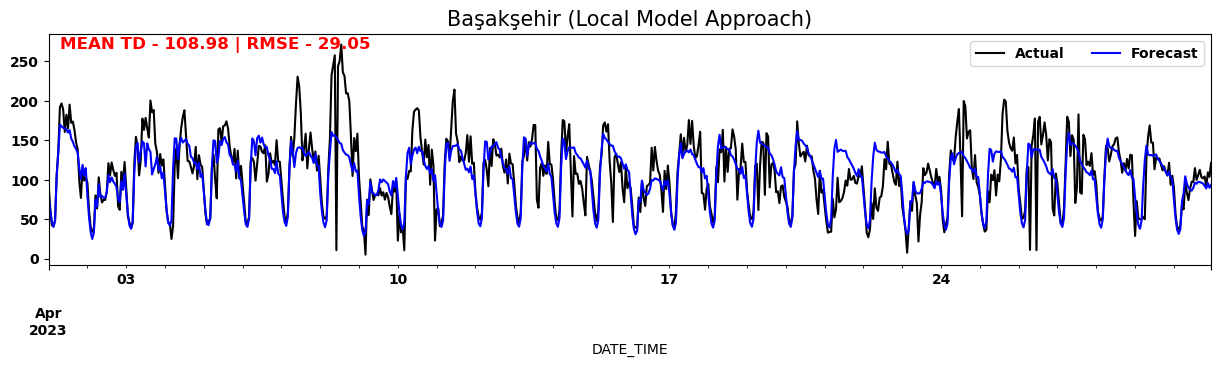

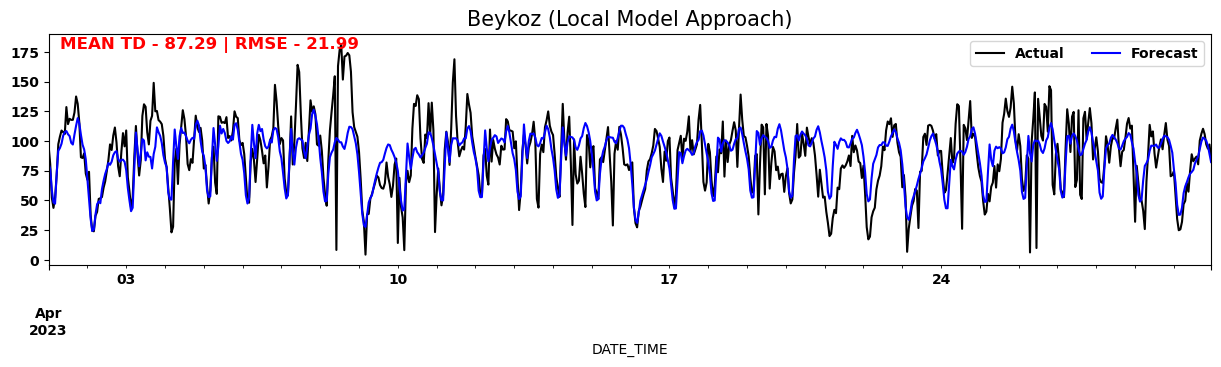

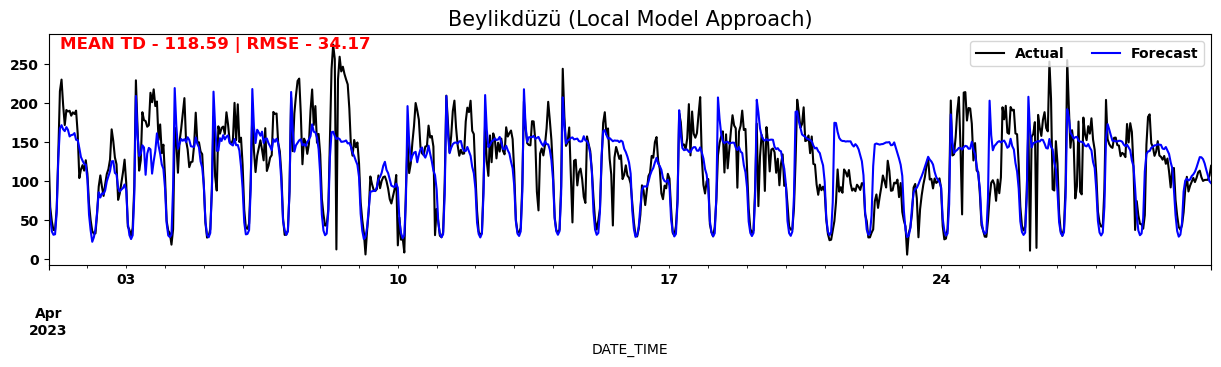

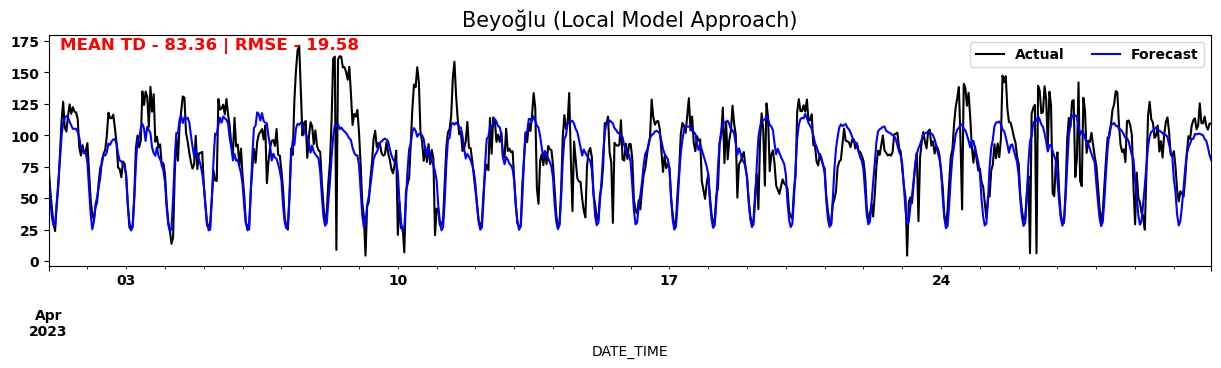

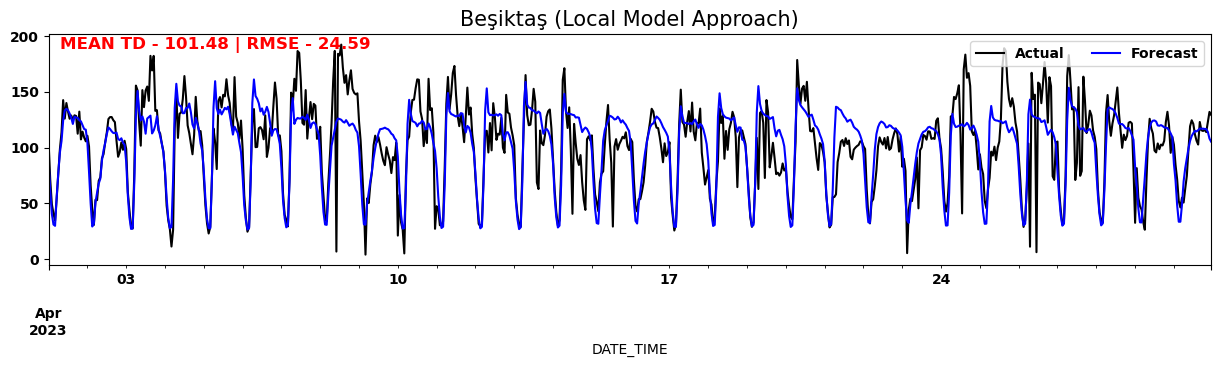

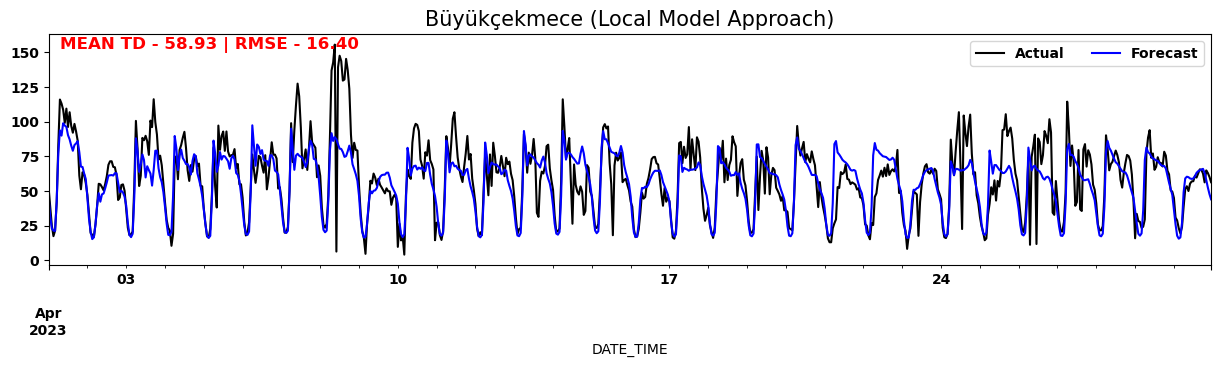

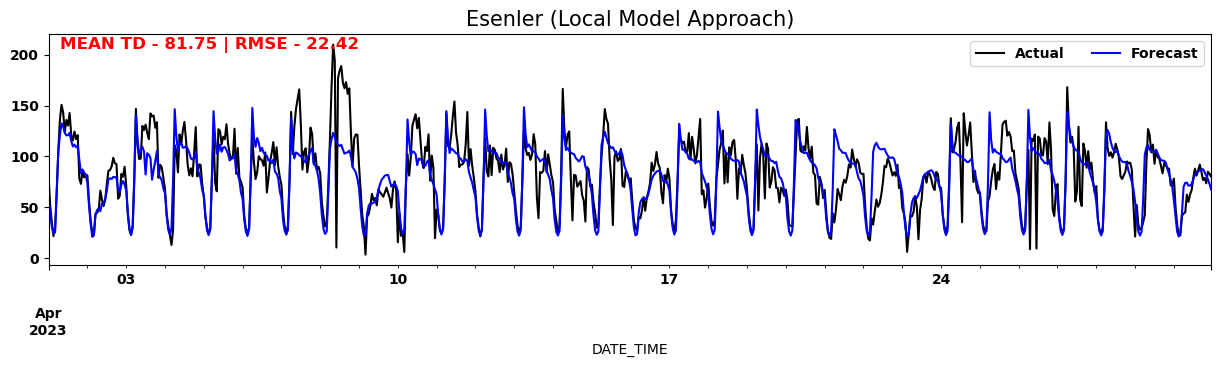

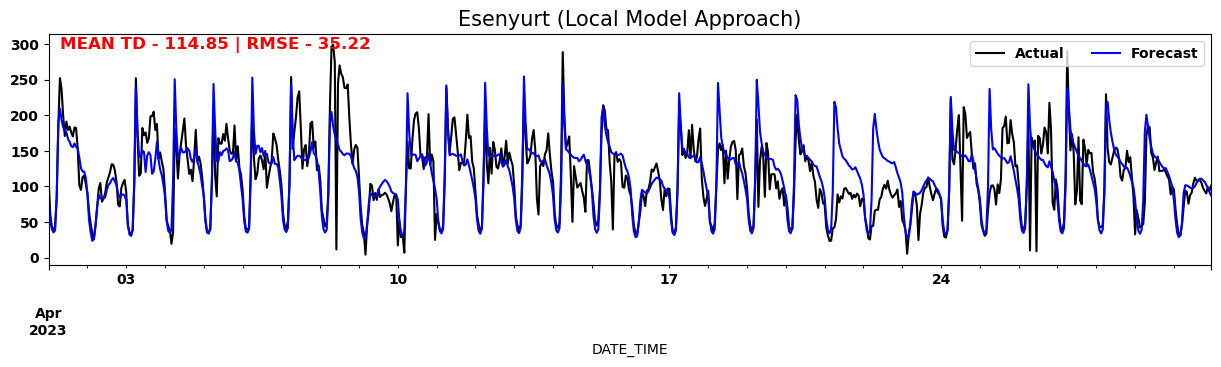

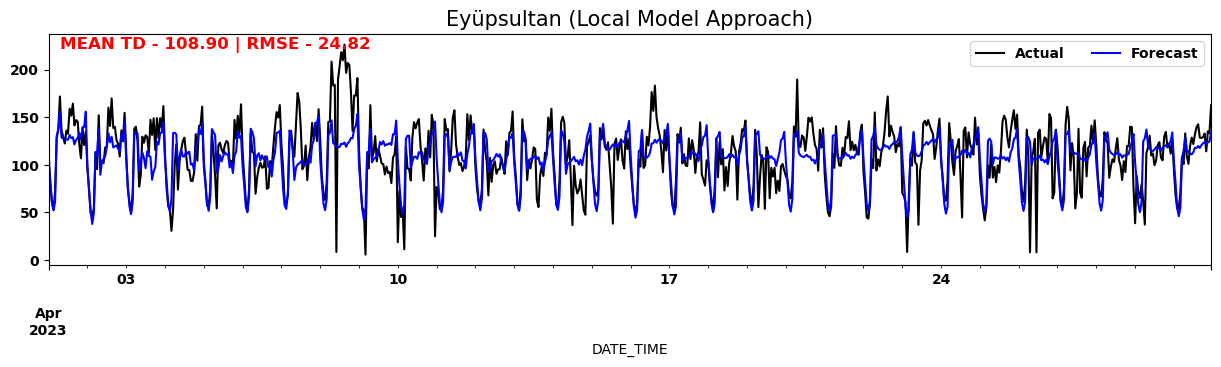

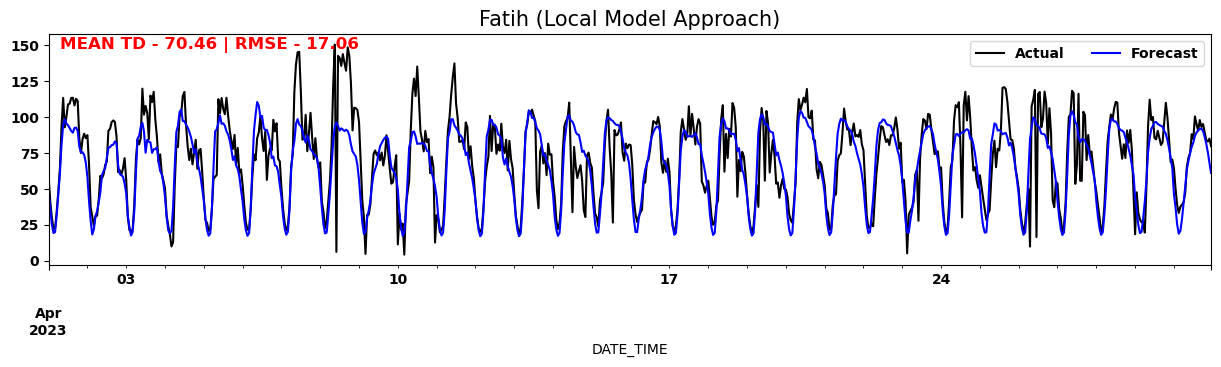

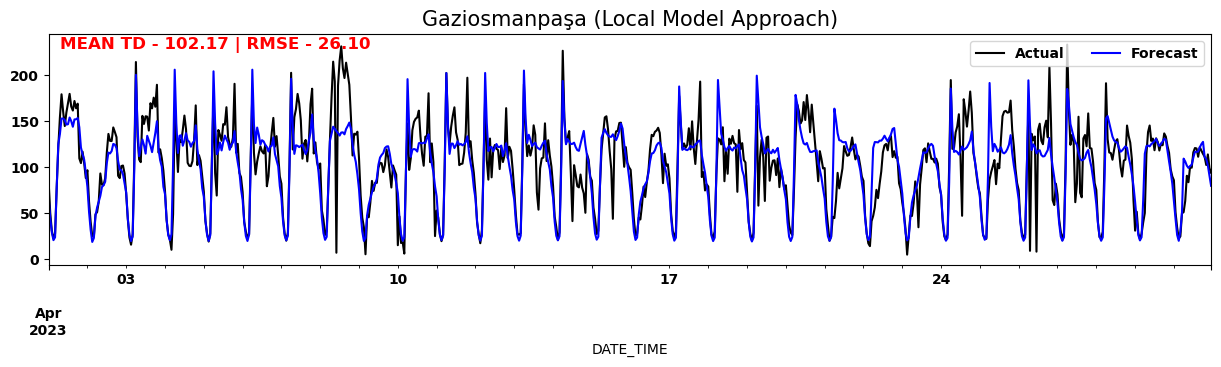

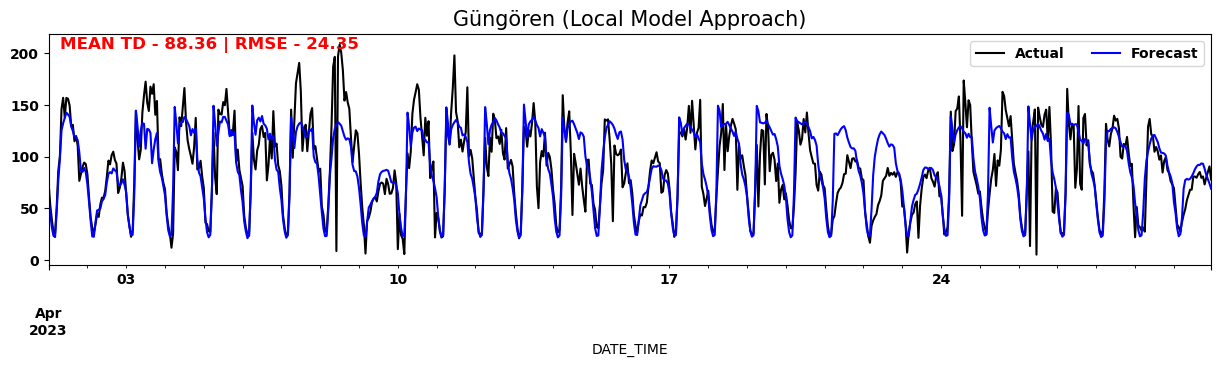

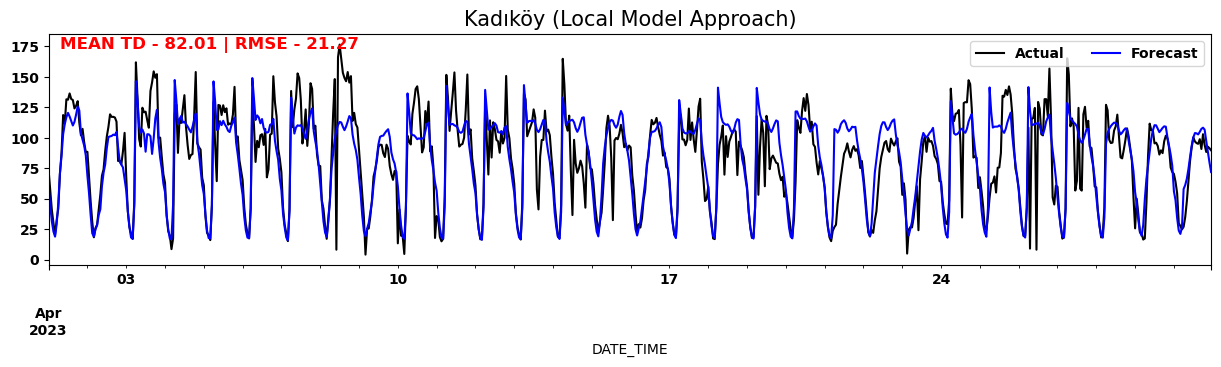

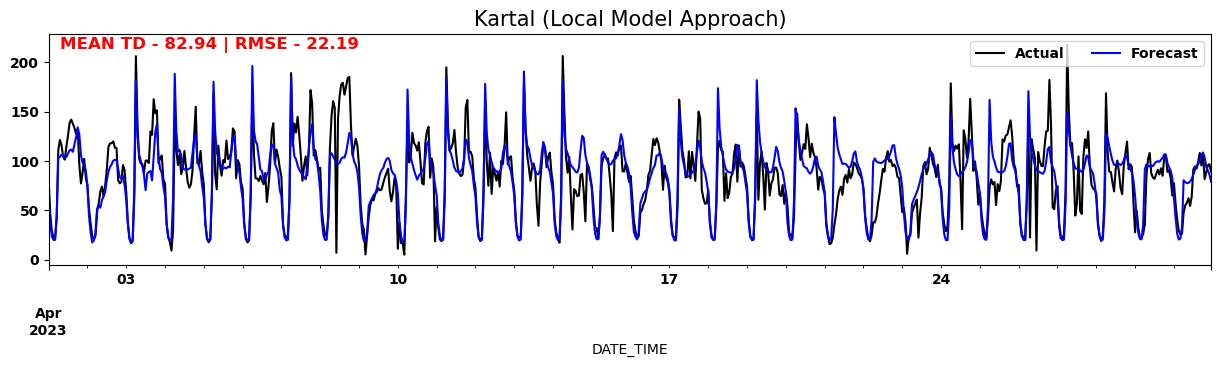

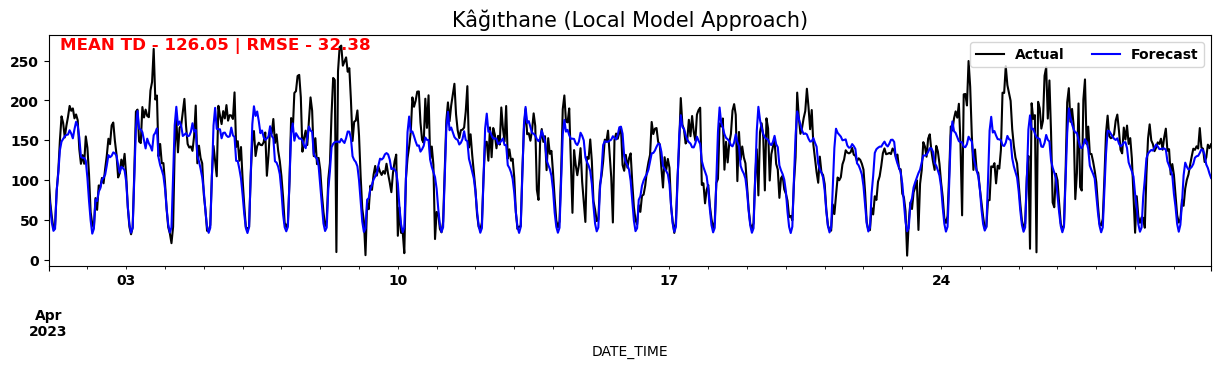

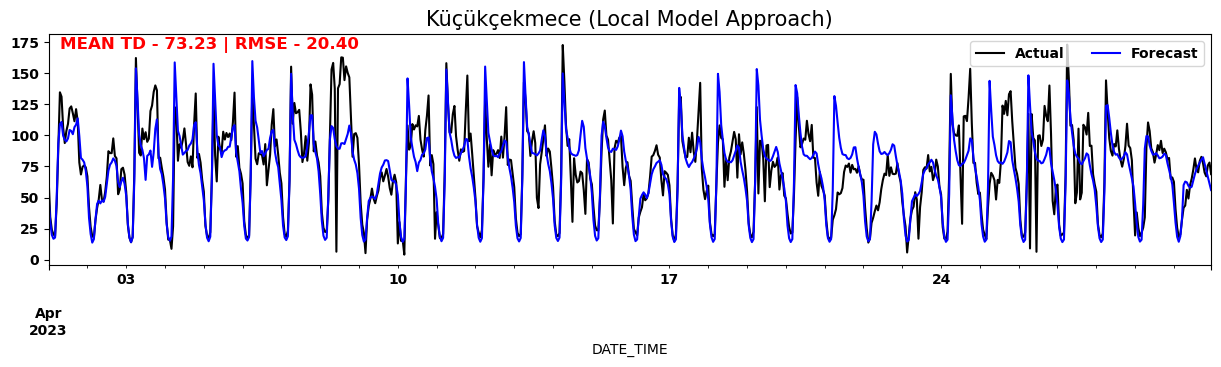

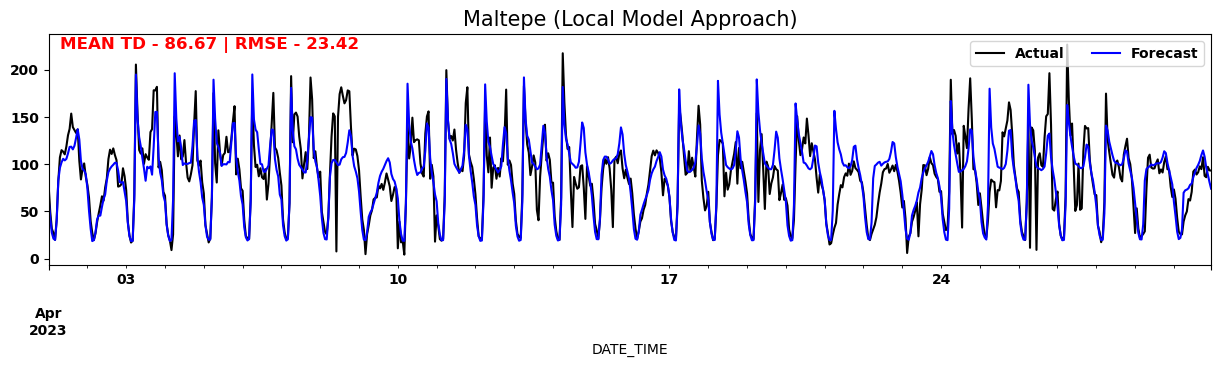

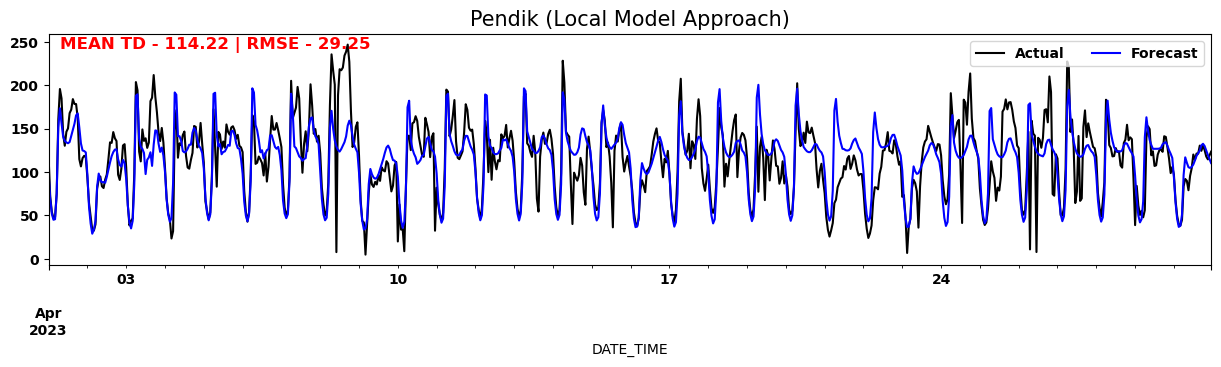

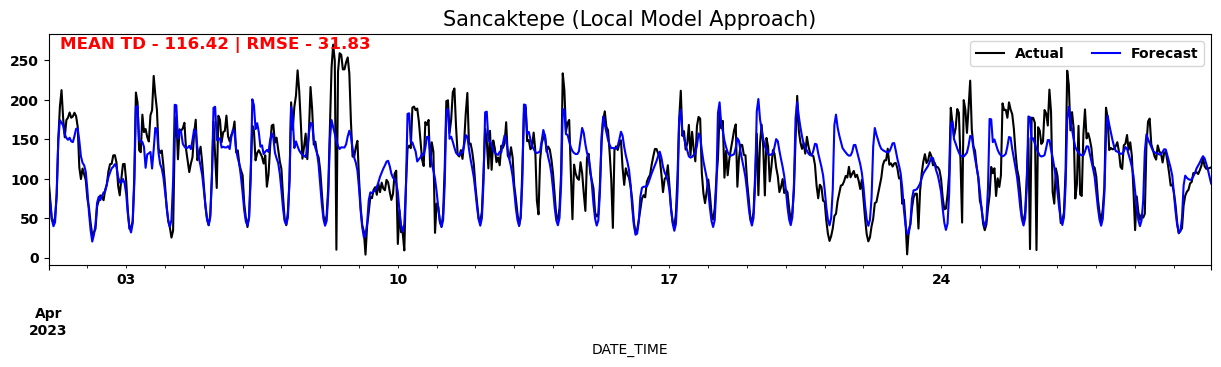

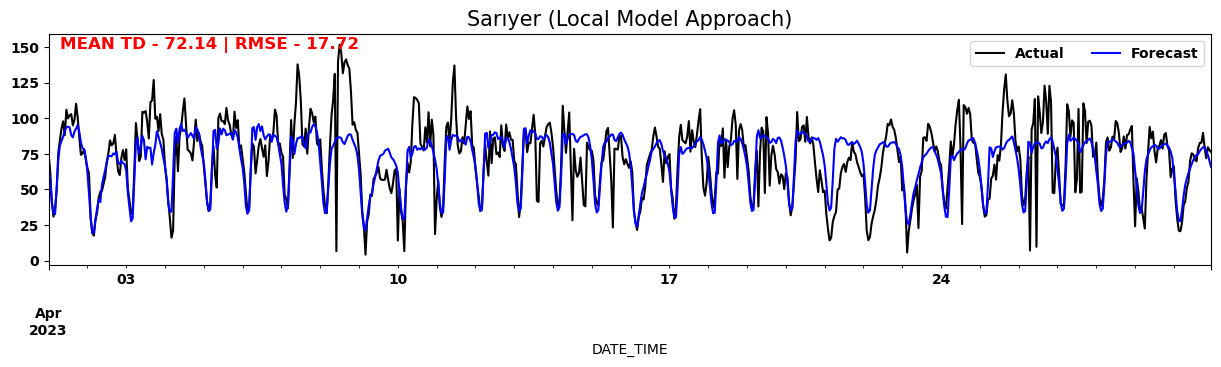

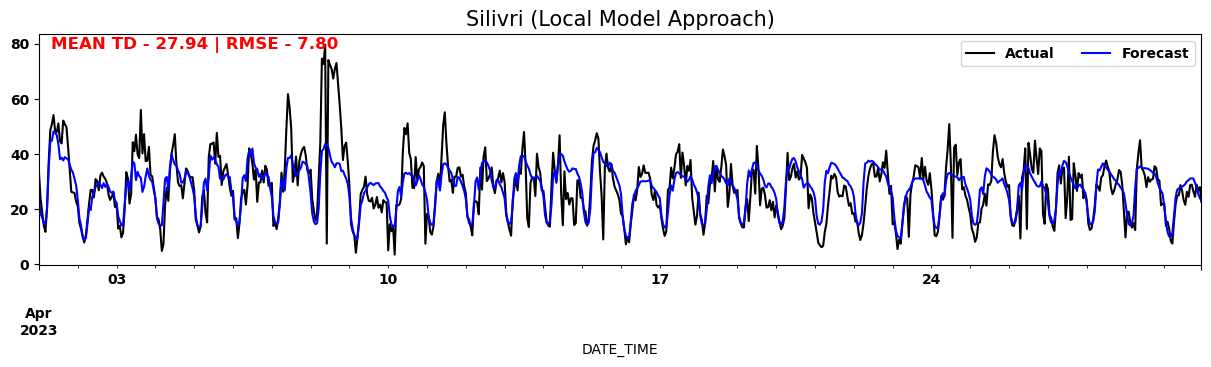

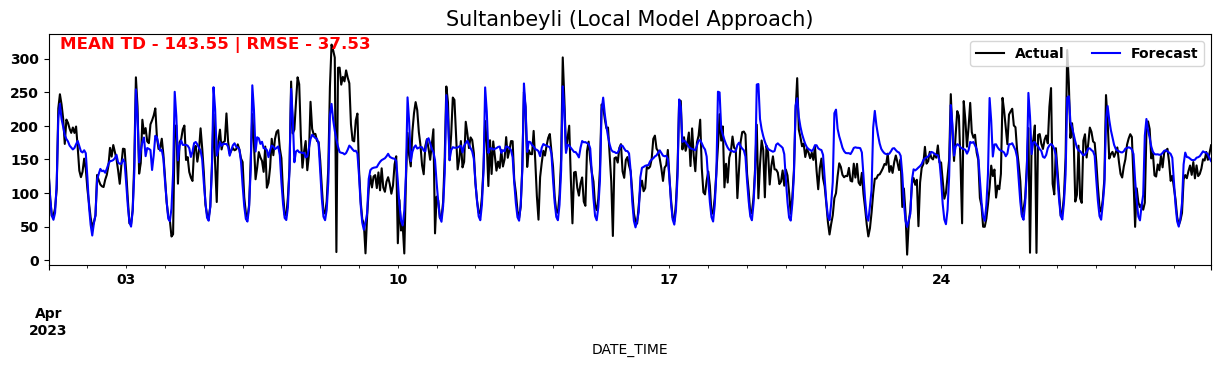

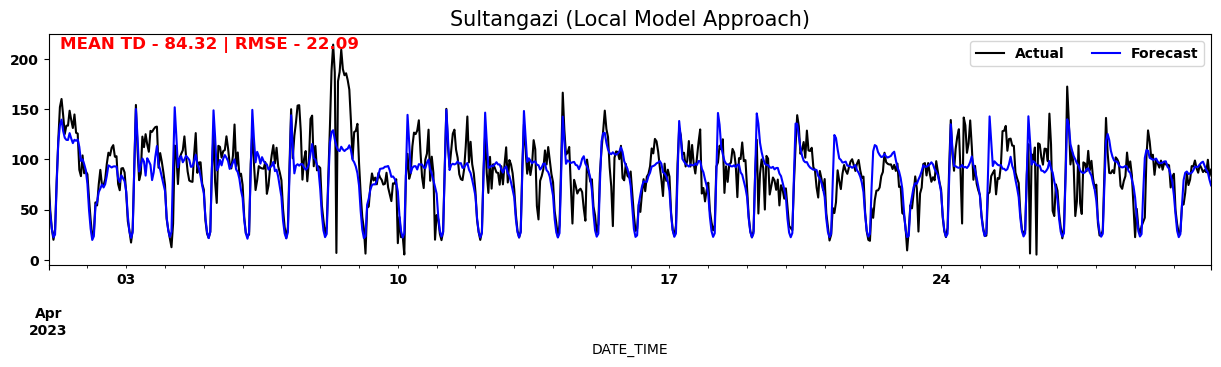

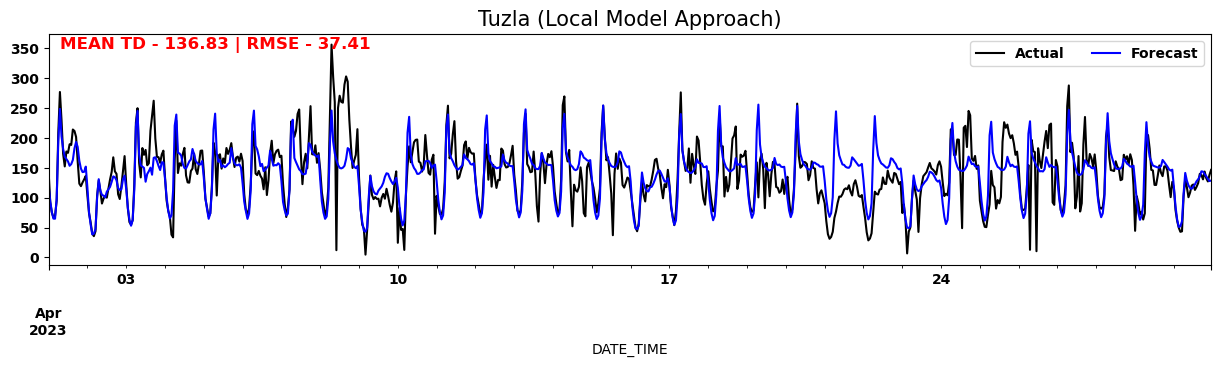

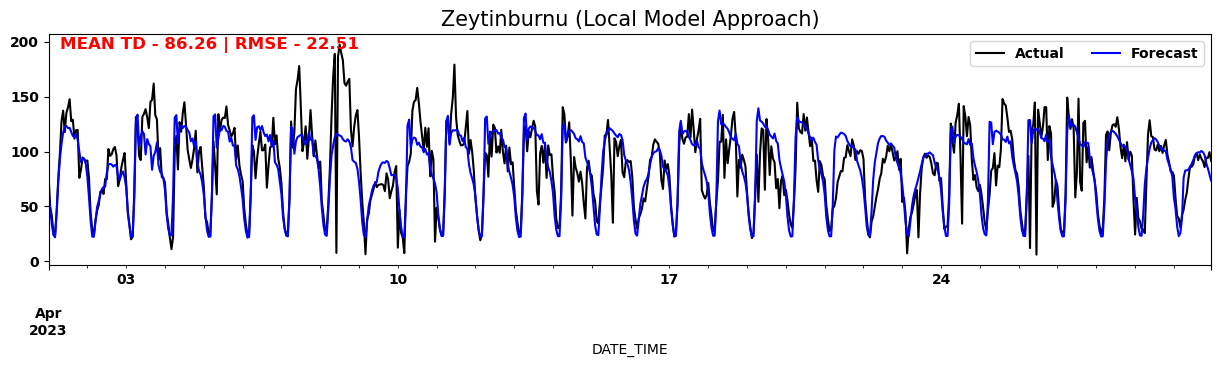

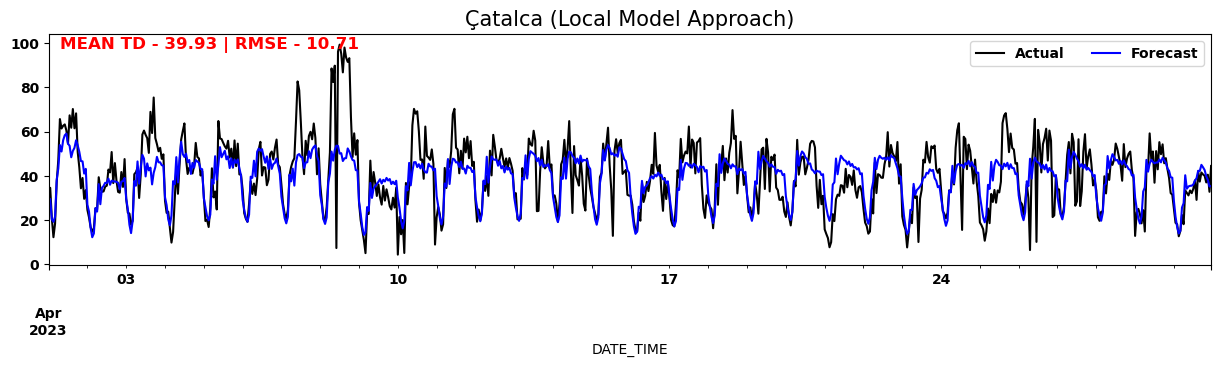

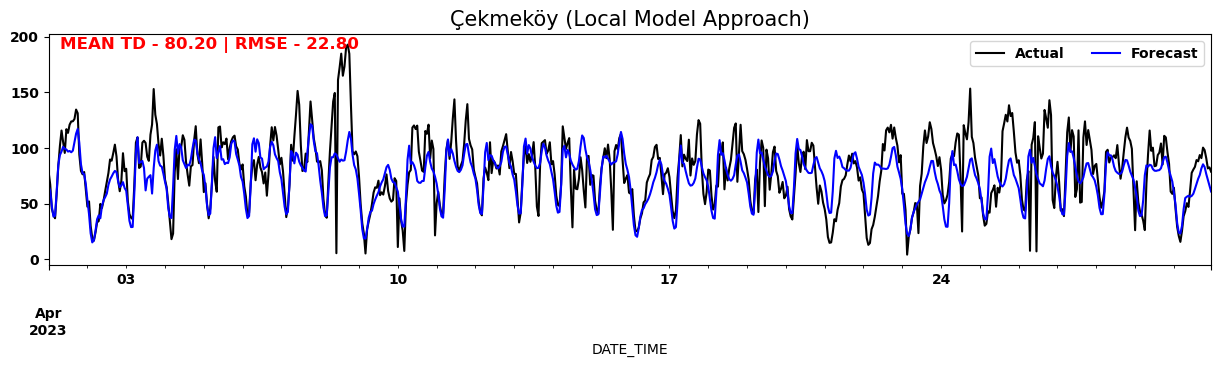

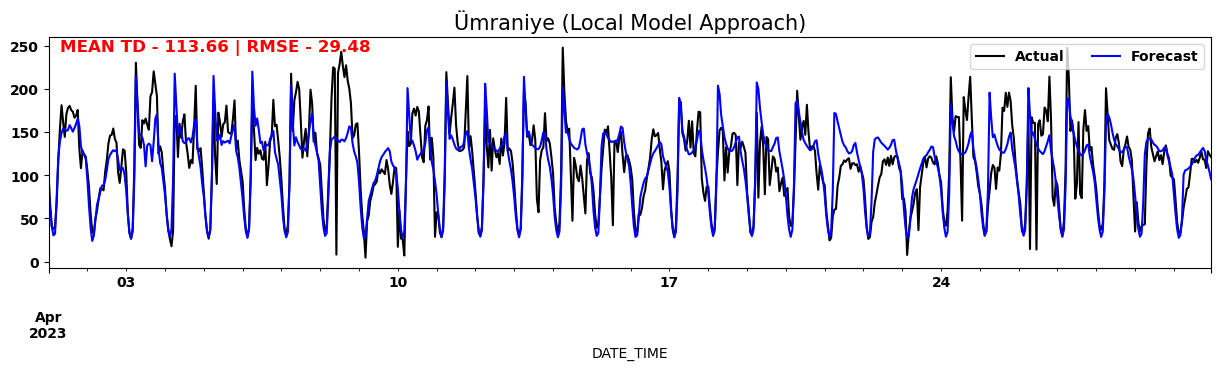

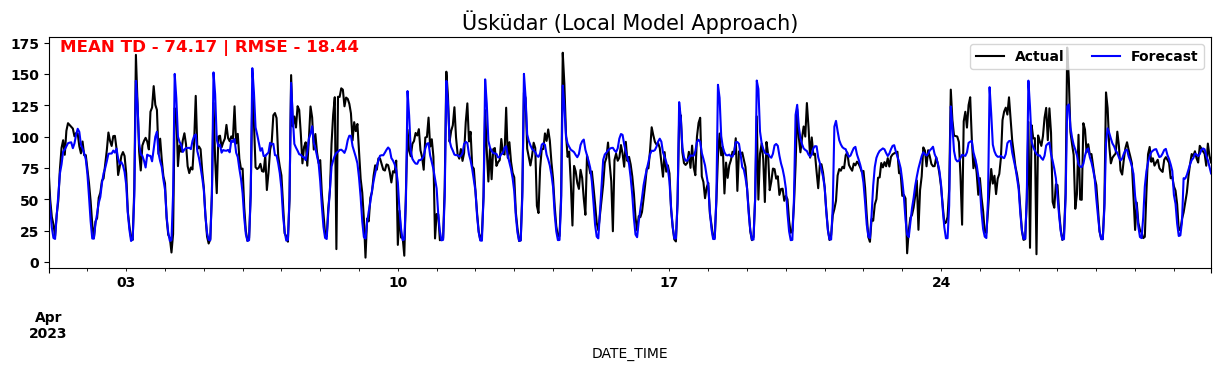

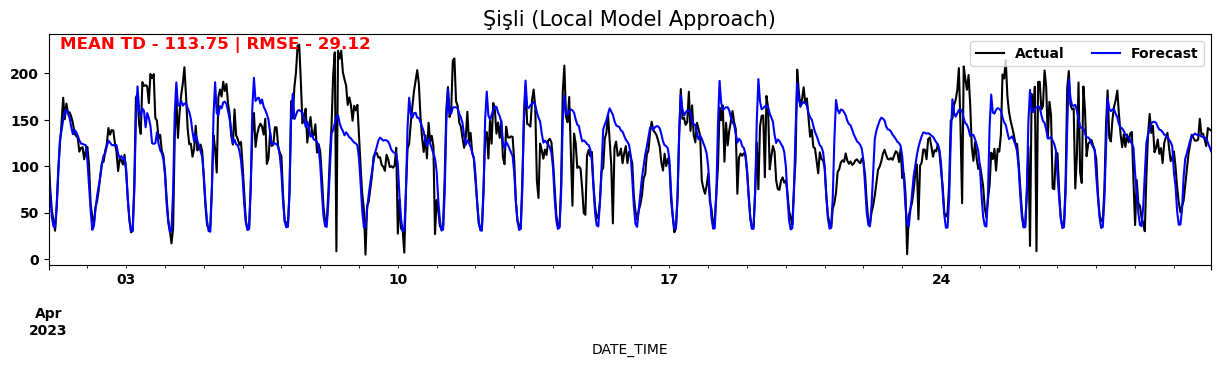

In [20]:
for district in districts:

    temp_df = (
        all_districts_forecasts.query(f"DISTRICT=='{district}'")
        .resample('H')[['NUMBER_OF_VEHICLES', 'FORECAST']].mean()
    )

    rmse = mean_squared_error(
        y_true=temp_df['NUMBER_OF_VEHICLES'],
        y_pred=temp_df['FORECAST'],
        squared=False
    )
    
    mean_td = temp_df['NUMBER_OF_VEHICLES'].mean()

    ax = (
        temp_df
        .plot(figsize=(15, 3), color=['k', 'blue'])
    )

    ax.set_title(f"{district} (Local Model Approach)", fontsize=15)

    ax.text(.01, .99, f'MEAN TD - {mean_td:.2f} | RMSE - {rmse:.2f}', ha='left', va='top', 
            transform=ax.transAxes, fontsize=12, fontweight='bold', color='r')
    
    ax.legend(ncol=2, loc='upper right', labels=['Actual', 'Forecast'])
    plt.show();